# KMeans Clustering Demo

This demo includes K means clustering on data of celebrities from Wikipedia .

Problem Description :

We have data of famous personalities along with their description (let’s say abstract from Wikipedia). Now we want to group people as per their work-type i.e. for instance people related to sports in one group, politicians in one ,actors in another and so on.

High Level Overview is :

1.Load the Raw Data

2.Tokenise and Remove StopWord from Data

3.Compute TF-IDF of each word in the corpus.

4.Fit the K means model on corpus.

5.Observe the celebrities in each cluster.

        Importing all the modules and classes required 

In [1]:
import pandas as pd
import numpy as np 
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.externals import joblib

    Loading the raw data as a pandas dataframe

In [3]:
input_data=pd.read_csv('../data/people_wiki.csv')

    Exploring the input_data

In [5]:
input_data.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


The dataframe contains 3 columns -->  URI,name and text .

Let's apply K means clustering on 'text' column on basis of TF-IDF score of each word .

The text need to be processed for counting the TF-IDF , so following steps should be followed.

1.Tokenization

2.StopWords Removal

3.Stemming



    Functions to Tokenize, Remove Stopwords and perform stemming on Text

In [12]:
def tokenize(p):
    tokenizer = RegexpTokenizer('\w+')
    words=p.lower().split()
    words=" ".join(words)
    tokenized_doc=" ".join(tokenizer.tokenize(words))
    return tokenized_doc

def unstopped(p):
    tokenizer = RegexpTokenizer('\w+')
    stop=tokenizer.tokenize(open('english.txt').read())
    pattern = re.compile(r'\b(' + r'|'.join(stop) + r')\b\s*')
    unstopped_text = pattern.sub('', p)
    return unstopped_text

def stemming(p):
    stemobj=EnglishStemmer()
    stemmed_text=map(stemobj.stem,p.split())
    stemmed_text=" ".join(stemmed_text)
    return stemmed_text

def filterText(text):
    return unstopped(tokenize(text))
        

    The 'filterText' function calls the above 3 'tokenize' , 'unstopped' and 'stemming' functions

Now we will be adding a new column 'filteredText' which will contain the text after tokenization , stopwords removal and stemming 

    Adding the 'filterText' column 

In [13]:
%time input_data['filteredText']=input_data.text.apply(lambda x:filterText(x))

Wall time: 2min 10s


    Displaying top entries of modified DataFrame

In [14]:
input_data.head()

,URI,name,text,filteredText
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born october 1979 australian rul...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred lewy aka sandy lewy graduated universit...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,harpdog brown singer harmonica player active c...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,franz rottensteiner born waidmannsfeld lower a...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,henry krvits born 30 december 1974 tallinn bet...


The next step is to create a corpus which contains text of all documents and then computing TF-IDF of all words 


    Creating the corpus

In [15]:
corpus=input_data.filteredText
corpus=np.array(corpus)

In [16]:
len(corpus)

59071

    Creating an instance of TfIdfVectorizer()

In [17]:
tfidf_vectorizer = TfidfVectorizer()

    Creating TFIDF matrix which contains TF-IDF of each word 

In [18]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

Wall time: 16.9 s


In [19]:
tfidf_matrix.shape

(59071, 547848)

In [20]:
print(tfidf_vectorizer.get_feature_names())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Now KMeans will be fitted to the data

    Specifing No. of Clusters

In [21]:
num_clusters = 5

    Fitting KMeans Clustering to tfidf_matrix

In [22]:
km = KMeans(n_clusters=num_clusters,random_state=1)

%time km.fit(tfidf_matrix)


Wall time: 38min 8s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

    Model can be saved and loaded for future use .

In [23]:
joblib.dump(km,  'people_cluster.pkl')
km = joblib.load('people_cluster.pkl')

    Getting Clusters

In [24]:
clusters = km.labels_.tolist()

    Preparing a Dictionary which contains names of people , their Description and Assigned Cluster

In [25]:
people = { 'name': np.array(input_data.name), 'text': np.array(input_data.text), 'cluster': clusters}

    Creating a data frame out of dictionary and selecting 'name' and 'cluster' of each person

In [26]:
frame = pd.DataFrame(people, index = [clusters] , columns = ['name', 'cluster'])

    Viewing Number of celebrities per Cluster

In [27]:
frame['cluster'].value_counts()

2    24872
0    11295
4     9280
3     8603
1     5021
Name: cluster, dtype: int64

Within Set Sum of Squared Errors 

In [28]:
km.inertia_

57601.471952663946

    Viweing 50 celeb names per cluster

In [29]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d names:" % (i+1), end='')
    for title in frame.ix[i]['name'].values.tolist()[0:50]:
        print(' %s,' % title, end='')
    print() 
    print() 
    
    print() 
    print() 

Top terms per cluster:

Cluster 1 names: Digby Morrell, Paddy Dunne (Gaelic footballer), Ceiron Thomas, Adel Sellimi, Vic Stasiuk, Leon Hapgood, Dom Flora, Bob Reece, Bob Adams (American football), Marc Logan, Corey Woolfolk, Alan Roper, Vladimir Yurchenko, Doug McIntosh, Shaka Hislop, Steve Castle, Dean Greig, James Stewart (American football), Fredrik Jacobson, Juan Pablo Montoya, Anna Kournikova, Al Hairston, Ron Shuman, Bill Young (Australian rules footballer), Se%C3%A1n %C3%93g %C3%93 hAilp%C3%ADn, Mike Trebilcock, Daniel Falzon, Cameron Sharp, Gary Fila, Roger James (footballer), Aled de Malmanche, Ian Mellor, Adrian Brooks, Ed Rubbert, Arturo J. Marcano Guevara, Cam Cairncross, John Taylor (cricketer, born 1937), Doug Heveron, Mike P%C3%A9rez (baseball), Mick O'Brien (footballer, born 1979), William Kipsang, David Pastr%C5%88%C3%A1k, Andreas Alm, Ronnie Wallwork, Henry Honiball, Roland De Wolfe, Keith Jennings (basketball), Alexi Lalas, Brett Hull, Jeoff Long,



Cluster 2 names

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


There are definately some more optimization 

1. How can we reduce the features ?

2. How to select the right number of clusters ?

Answer to Question 1

    Well let's do something with TF-IDF Vectorizer 
    
    We will add 2 more parameters to TF-IDF Vectorizer : min_df and max_df

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 90% of the documents it probably cares little meanining (in the context of person's desciption)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered.

In [33]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.1,max_df=0.9)

In [34]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

Wall time: 18 s


In [35]:
tfidf_matrix.shape

(59071, 139)

In [36]:
n_clusters=5
km = KMeans(n_clusters=num_clusters,random_state=1)
%time km.fit(tfidf_matrix)

Wall time: 4min 13s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [37]:
km.inertia_  #"Within Set Sum of Squared Errors"

45992.6990286207

    Let's Apply Singular Vector Decomposition

In [38]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
%time X = svd.fit_transform(tfidf_matrix)
X.shape

Wall time: 1.16 s


(59071, 10)

In [39]:
n_clusters=5
km = KMeans(n_clusters=num_clusters,random_state=1)
%time km.fit(X)

Wall time: 4.58 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [40]:
km.inertia_   #"Within Set Sum of Squared Errors"

6628.4912804280684

Answer to Question 2

How to decide upon the right number of clusters ?

The ELBOW Method

In [41]:
#Elbow Method
res=[]
for k in range(2,30):
    kmeans = KMeans(n_clusters=k,random_state=1)
    model=kmeans.fit(X)
    wssse=kmeans.inertia_
    KW=(k,wssse)
    KW
    res.append(KW)

In [42]:
res

[(2, 10152.733108413147),
 (3, 8654.5152453689607),
 (4, 7553.022200536494),
 (5, 6628.4912804280684),
 (6, 5791.0278760060146),
 (7, 5252.6188845604674),
 (8, 4818.6173331750997),
 (9, 4483.5410509565718),
 (10, 4217.456718707559),
 (11, 4032.1803764428923),
 (12, 3889.4460974024923),
 (13, 3755.0905596785087),
 (14, 3647.6389218101931),
 (15, 3559.3646545020301),
 (16, 3471.6410667921414),
 (17, 3395.9927496972036),
 (18, 3328.9309049910976),
 (19, 3275.2381104486221),
 (20, 3228.1918160742871),
 (21, 3168.7596106754431),
 (22, 3126.0230601574499),
 (23, 3085.7035677656058),
 (24, 3041.7362257505506),
 (25, 3006.7320780963),
 (26, 2965.3276733816033),
 (27, 2925.7495591395896),
 (28, 2889.7005987364219),
 (29, 2865.7650717189767)]

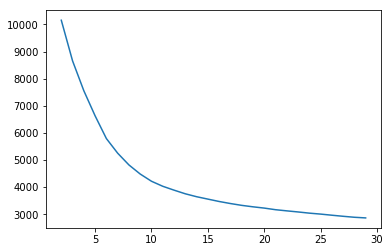

In [43]:
import matplotlib.pyplot as plt
plt.plot(*zip(*res))
plt.show()

There are many more ways to deal with this problem of deciding upon right number of clusters.
But here only Elbow Method demonstrated.

In [53]:
n_clusters=9
km = KMeans(n_clusters=n_clusters,random_state=1)
%time km.fit(tfidf_matrix)

Wall time: 6min 38s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [54]:
joblib.dump(km,  'people_cluster1.pkl')
km = joblib.load('people_cluster1.pkl')

In [55]:
clusters = km.labels_.tolist()

In [56]:
people = { 'name': np.array(input_data.name), 'text': np.array(input_data.text), 'cluster': clusters}

In [57]:
frame = pd.DataFrame(people, index = [clusters] , columns = ['name', 'cluster'])

In [58]:
frame['cluster'].value_counts()

2    13339
0    10448
1     6502
3     6414
6     5697
4     5015
7     4716
8     4100
5     2840
Name: cluster, dtype: int64

In [59]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(n_clusters):
    print("Cluster %d names:" % (i+1), end='')
    for title in frame.ix[i]['name'].values.tolist()[0:50]:
        print(' %s,' % title, end='')
    print() 
    print() 
    
    print() 
    print() 

Top terms per cluster:

Cluster 1 names: David Chernushenko, Mindaugas Murza, Steven Weil, Gary Emineth, Bob Adams (American football), Sylvie Roy, Robert N. Chatigny, Susan Westerberg Prager, William J. Ely, John Reynolds (Canadian politician), Anerood Jugnauth, Abdel Fattah el-Sisi, Steven Point, L%C3%A1zaro C%C3%A1rdenas Batel, Carlos Bea, Marilyn Hall Patel, Yolande Thibeault, Rajiv Shah, Frits Bolkestein, Mario Michel, Pavlo Khazan, Gulzar Banu, David M. Becker, Renny Pritikin, Christy Burke, George Brent Mickum IV, Dave Chomiak, Atu Emberson Bain, Robert Watt, Leonardo %C3%81lvarez Romo, Paul McGrath (politician), Uffe Elb%C3%A6k, James Danko, Daniel Janssen, Gary Nolan (radio host), Ray Sansom, Qayyum Inamdar, Russell Reid, Thomas B. Hayward, Camilo Nogueira Rom%C3%A1n, Gijs de Vries, Vytautas %C5%A0ustauskas, Peter Maurer, Leura Canary, Kenneth Binks, John Ladenburg, Rajiva Wijesinha, Ruben Zackhras, Isabel Allende (politician), Edward Leigh,



Cluster 2 names: Alfred J. Lewy,

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


In [64]:
from sklearn.manifold import TSNE

In [71]:
xx = TSNE(n_components=2).fit_transform(tfidf_matrix.toarray())

MemoryError: 